In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from transformers import CLIPModel, CLIPImageProcessor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        """
        features: (N, feat_dim)
        labels:   (N,) long
        """
        batch_size = features.size(0)
        centers_batch = self.centers.index_select(0, labels.long())
        center_loss = torch.sum((features - centers_batch) ** 2) / (2.0 * batch_size)
        return center_loss


class MultiClassFocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        # inputs: (N, C) logits if self.logits=True; else probs
        # targets: (N,) long
        if self.logits:
            bce = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        else:
            bce = -torch.log(inputs[range(targets.shape[0]), targets].clamp(min=1e-12))
        pt = torch.exp(-bce)
        f_loss = self.alpha * (1 - pt) ** self.gamma * bce
        return f_loss.mean() if self.reduce else f_loss


class FocalCenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device, alpha=1, gamma=2, logits=True, reduce=True,
                 center_weight=1.0, focal_weight=1.0):
        super(FocalCenterLoss, self).__init__()
        self.center_loss = CenterLoss(num_classes, feat_dim, device)
        self.focal_loss = MultiClassFocalLoss(alpha, gamma, logits, reduce)
        self.center_weight = center_weight
        self.focal_weight = focal_weight

    def forward(self, features, labels, outputs):
        # features: (N, feat_dim)  | labels: (N,) long | outputs: (N, C) logits
        loss_center = self.center_loss(features, labels)
        loss_focal  = self.focal_loss(outputs, labels)
        return self.center_weight * loss_center + self.focal_weight * loss_focal


# ------------------------- Config -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
batch_size = 128
epochs = 10

# Projection (embedding) size for center loss space
feat_dim = 256

# Loss weights
center_weight = 0.01    # tune 0.005–0.05
focal_weight  = 1.0

# Checkpoint path
save_path = "best_clip_fcl.pt"

processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
MEAN, STD = processor.image_mean, processor.image_std
SIZE = processor.size["shortest_edge"] if isinstance(processor.size, dict) else processor.size

transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
num_classes = len(train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

# ------------------------- Backbone: CLIP ViT-B/32 (frozen) -------------------------
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", weights_only=False).to(device)
for p in clip.parameters():
    p.requires_grad = False
clip.eval()

# CLIP image embedding dim after visual projection
feat_dim_backbone = clip.visual_projection.out_features  # usually 512

@torch.no_grad()
def clip_image_features(imgs: torch.Tensor) -> torch.Tensor:
    """
    imgs: (N,3,H,W) already CLIP-normalized
    returns: (N, feat_dim_backbone) projected image embeddings
    """
    vis_out = clip.vision_model(pixel_values=imgs)  # .pooler_output: (N, hidden)
    pooled = vis_out.pooler_output
    feats = clip.visual_projection(pooled)          # (N, feat_dim_backbone)
    return feats

# ------------------------- Projection + Classifier + Loss -------------------------
proj = nn.Linear(feat_dim_backbone, feat_dim).to(device)      # trainable projection to center-loss space
cls_head = nn.Linear(feat_dim, num_classes).to(device)        # multiclass head (logits)

criterion = FocalCenterLoss(
    num_classes=num_classes,
    feat_dim=feat_dim,
    device=device,
    alpha=1.0,
    gamma=2.0,
    logits=True,
    reduce=True,
    center_weight=center_weight,
    focal_weight=focal_weight,
).to(device)

optimizer = optim.Adam([
    {"params": proj.parameters(), "lr": 1e-3},
    {"params": cls_head.parameters(), "lr": 1e-3},
    {"params": criterion.center_loss.parameters(), "lr": 5e-4},  # smaller LR for centers
])

# ------------------------- Train / Eval -------------------------
def train_one_epoch():
    proj.train(); cls_head.train()
    running = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():                      # backbone frozen
                f_clip = clip_image_features(imgs)     # (N, feat_dim_backbone)
            feats = proj(f_clip)                       # (N, feat_dim)
            logits = cls_head(feats)                   # (N, C)
            loss = criterion(feats, y, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    proj.eval(); cls_head.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = proj(clip_image_features(imgs))
        logits = cls_head(feats)
        loss = criterion(feats, y, logits)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


class_to_idx: {'Negative': 0, 'Positive': 1}


In [3]:

# ------------------------- Run + Save-Best -------------------------
# best_acc = 0.0
for epoch in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()

    if acc > best_acc:
        best_acc = acc
        torch.save({
            "epoch": epoch + 1,
            "clip_state_dict": clip.state_dict(),                 # frozen, saved for reproducibility
            "proj_state_dict": proj.state_dict(),
            "cls_state_dict": cls_head.state_dict(),
            "center_state_dict": criterion.center_loss.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc,
            "num_classes": num_classes,
            "feat_dim": feat_dim,
            "feat_dim_backbone": feat_dim_backbone,
        }, save_path)
        print(f"✅ New best acc: {best_acc:.3f} — saved to {save_path}")

    print(f"Epoch {epoch+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")

print(f"🔥 Done. Best Acc: {best_acc:.3f}")

Epoch 1/10 | train_loss 0.3411 | val_loss 0.3340 | acc 0.862


Epoch 2/10 | train_loss 0.3341 | val_loss 0.3418 | acc 0.811


✅ New best acc: 0.876 — saved to best_clip_fcl.pt
Epoch 3/10 | train_loss 0.3274 | val_loss 0.3226 | acc 0.876


✅ New best acc: 0.885 — saved to best_clip_fcl.pt
Epoch 4/10 | train_loss 0.3172 | val_loss 0.3064 | acc 0.885


Epoch 5/10 | train_loss 0.3050 | val_loss 0.2992 | acc 0.876


Epoch 6/10 | train_loss 0.2989 | val_loss 0.2907 | acc 0.876


Epoch 7/10 | train_loss 0.2955 | val_loss 0.2855 | acc 0.871


Epoch 8/10 | train_loss 0.2857 | val_loss 0.2782 | acc 0.871


✅ New best acc: 0.908 — saved to best_clip_fcl.pt
Epoch 9/10 | train_loss 0.2775 | val_loss 0.2724 | acc 0.908


Epoch 10/10 | train_loss 0.2752 | val_loss 0.2647 | acc 0.899
🔥 Done. Best Acc: 0.908


In [4]:
# ------------------------- (Optional) How to load later -------------------------
ckpt = torch.load(save_path, map_location=device)
clip.load_state_dict(ckpt["clip_state_dict"])
proj.load_state_dict(ckpt["proj_state_dict"])
cls_head.load_state_dict(ckpt["cls_state_dict"])
criterion.center_loss.load_state_dict(ckpt["center_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
print(f"Loaded. best_acc={ckpt['best_acc']:.3f}, epoch={ckpt['epoch']}")

Loaded. best_acc=0.908, epoch=9


              precision    recall  f1-score   support

    Negative     0.9477    0.9236    0.9355       157
    Positive     0.8125    0.8667    0.8387        60

    accuracy                         0.9078       217
   macro avg     0.8801    0.8951    0.8871       217
weighted avg     0.9103    0.9078    0.9087       217

Confusion Matrix:
 [[145  12]
 [  8  52]]


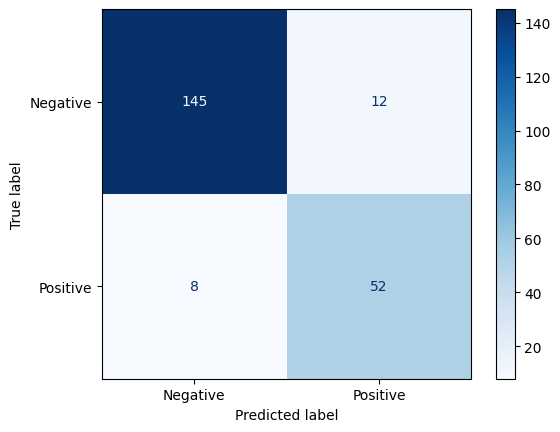

In [5]:

# ------------------------- Reports -------------------------
@torch.no_grad()
def collect_preds():
    proj.eval(); cls_head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = proj(clip_image_features(imgs))
        logits = cls_head(feats)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()


